<a href="https://colab.research.google.com/github/Qualot/deep-learning-from-scratch/blob/colab/ch05/TwoLayeresNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from keras.datasets import mnist
from keras.utils import to_categorical
from tqdm import tqdm

In [2]:
np.set_printoptions(linewidth=10000)

#common functions

In [3]:
def sigmoid(x):
  return 1/(1 + np.exp(-x))

In [24]:
def softmax(x):
  if x.ndim == 2:
      x = x.T
      x = x - np.max(x, axis=0)
      y = np.exp(x) / np.sum(np.exp(x), axis=0)
      return y.T

  x = x - np.max(x) # オーバーフロー対策
  return np.exp(x) / np.sum(np.exp(x))

In [5]:
def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)

  batch_size = y.shape[0]
  return -np.sum(t * np.log(y + 1e-7)) / batch_size

#Numerical gradient functions

In [6]:
def _numerical_gradient_wo_batch(f, x):
  h = 1e-4
  grad = np.zeros_like(x)

  for idx in range(x.size):
    tmp_val = x[idx]

    #f(x+h)
    x[idx] = tmp_val + h
    fxh1 = f(x)

    #f(x+h)
    x[idx] = tmp_val - h
    fxh2 = f(x)

    grad[idx] = (fxh1 - fxh2) / (2*h)
    x[idx] = tmp_val

  return grad

In [7]:
def numerical_gradient(f, x):
  if x.ndim == 1:
    return _numerical_gradient_wo_batch(f, x)

  grad = np.zeros_like(x)
  for key, xvec in enumerate(x):
    grad[key] = _numerical_gradient_wo_batch(f, xvec)

  return grad

#Backpropagation using Computational Graph

In [8]:
class MulLayer:
  def __init__(self,):
    self.x = None
    self.y = None

  def forward(self, x, y):
    self.x = x
    self.y = y
    out = x * y
    return out

  def backward(self, dout):
    dx = dout * self.y #flip x and y
    dy = dout * self.x

    return dx, dy

In [9]:
class AddLayer:
  def __init__(self):
    pass

  def forward(self, x, y):
    out = x + y
    return out

  def backward(self, dout):
    dx = dout * 1
    dy = dout * 1
    return dx, dy

In [10]:
class Relu:
  def __init__(self):
    self.mask = None

  def forward(self, x):
    self.mask = (x <= 0)
    out = x.copy()
    out[self.mask] = 0

    return out

  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout

    return dx

In [11]:
class Sigmoid:
  def __init__(self):
    self.out = None

  def forward(self, x):
    out = 1 / (1 + np.exp(-x))
    self.out = out
    return out

  def backward(self, dout):
    dx = dout * (1.0 - self.out) * self.out
    return dx

In [12]:
class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.dW = None
    self.db = None

  def forward(self, x):
    self.x = x
    out = np.dot(x, self.W) + self.b
    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis=0)
    return dx

In [13]:
class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)
    return self.loss

  def backward(self, dout=1):
    batch_size = self.t.shape[0]
    dx = (self.y - self.t) / batch_size
    return dx

#Load MNIST and postprocessing (normalize, flatten, one-hot)

11490434/11490434 [==============================] - 0s 0us/step
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82  82  56  39   0   0   0   0   0]
 [  0   0   0  

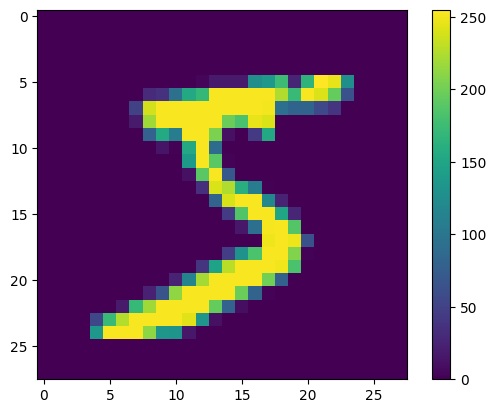

In [14]:
(x_train, t_train), (x_test, t_test) = mnist.load_data()
print(x_train[0])
plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [15]:
#normalize
x_train, x_test = x_train / 255.0, x_test / 255.0

#flatten
x_train, t_train, x_test, t_test = [arr.reshape(arr.shape[0], -1) for arr in (x_train, t_train, x_test, t_test)]

#one-hot
t_train = to_categorical(t_train)
t_test = to_categorical(t_test)

#TwoLayerNet class

In [16]:
class TwoLayerNet:
  def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
    #initialize weights and biasses
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

    #layers
    self.layers = OrderedDict()
    self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
    self.layers['Relu1'] = Relu()
    self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
    self.lastLayer = SoftmaxWithLoss()


  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)

    return x

  #x: input data, t: teacher data
  def loss(self, x, t):
    y = self.predict(x)

    return self.lastLayer.forward(y, t)

  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    if t.ndim != 1:
      t = np.argmax(t, axis=1)

    accuracy = np.sum(y == t) / float(x.shape[0])
    return accuracy

  #x: input, t: teacher
  def numerical_gradient(self, x, t):
    loss_W = lambda W: self.loss(x, t)

    grads = {}
    grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
    grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
    grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
    grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
    return grads

  def gradient(self, x, t):
    # forward
    self.loss(x, t)

    # backward
    dout = 1
    dout = self.lastLayer.backward(dout)

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)

    # configuration
    grads = {}
    grads['W1'] = self.layers['Affine1'].dW
    grads['b1'] = self.layers['Affine1'].db
    grads['W2'] = self.layers['Affine2'].dW
    grads['b2'] = self.layers['Affine2'].db

    return grads

#Practice part (argmax() for accuracy)

In [17]:
a = np.random.randn(10, 5)
print(a)
b = np.random.randn(10, 5)
print(b)

a = np.argmax(a, axis=1)
b = np.argmax(b, axis=1)
print(a)
print(b)
print(a==b)

[[ 1.21114719 -1.58072915  0.74582423  0.59267381  2.6736105 ]
 [ 0.47643464  1.12637056  1.0741597   0.36013094  0.15007071]
 [-0.05256795  0.31971191  0.30898846  0.52896812 -0.17870294]
 [-0.34852784  1.1418131   2.04071837  0.4029612   0.64675865]
 [ 0.25015096  0.50154642 -0.67275181 -0.04237061  2.25272335]
 [ 0.33956901 -0.23635254  0.84493349 -0.55589301  0.60450245]
 [-0.76953325  0.22176294 -0.6441631  -0.94079505 -0.68585291]
 [-1.60112448 -0.41695474  0.65243661 -0.47786824 -0.8098917 ]
 [ 0.06564137  1.06841321  0.29317367  1.48908668  0.41584045]
 [ 0.86535539  0.55996183 -1.47247077 -0.78596685  1.16518661]]
[[-0.67649368 -0.40439009 -0.78931983 -0.23939943  0.7832314 ]
 [-0.65491486  1.02070426  0.00593273 -0.69370238  0.09310729]
 [ 0.93316275  0.28463583 -0.53314921 -1.06365411  0.3104912 ]
 [-0.4298293  -0.40059455  1.99706642  0.18129344  1.49689057]
 [-0.88231082 -0.51448337  0.47524621 -0.57667758 -1.56479894]
 [-0.66235759  1.19422332 -0.38699123 -0.8789564   0.8

In [18]:
alist = np.random.randn(10, 2)
print(alist)
for key, avec in enumerate(alist):
  print(f"{key} th ... {avec}")

[[-1.17218375  0.97757734]
 [ 0.33159408  0.02672991]
 [ 2.15916734 -1.62638604]
 [ 0.40514907  1.48749888]
 [-0.5605195  -0.73996515]
 [ 1.80904437 -0.60282324]
 [-1.1842469  -0.1501911 ]
 [-0.79973322 -0.16324649]
 [-1.39962403 -0.4560274 ]
 [-0.7741496  -0.33478262]]
0 th ... [-1.17218375  0.97757734]
1 th ... [0.33159408 0.02672991]
2 th ... [ 2.15916734 -1.62638604]
3 th ... [0.40514907 1.48749888]
4 th ... [-0.5605195  -0.73996515]
5 th ... [ 1.80904437 -0.60282324]
6 th ... [-1.1842469 -0.1501911]
7 th ... [-0.79973322 -0.16324649]
8 th ... [-1.39962403 -0.4560274 ]
9 th ... [-0.7741496  -0.33478262]


#Practice part (TwoLayerNet)

In [19]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


In [20]:
x = np.random.rand(100, 784)
y = net.predict(x)

In [21]:
t = np.random.rand(100, 10)
#grads = net.numerical_gradient(x, t)

#Practice part (using MNIST)

In [22]:
(x_train, t_train), (x_test, t_test) = mnist.load_data()
#normalize
x_train, x_test = x_train / 255.0, x_test / 255.0

#flatten
x_train, t_train, x_test, t_test = [arr.reshape(arr.shape[0], -1) for arr in (x_train, t_train, x_test, t_test)]

#one-hot
t_train = to_categorical(t_train)
t_test = to_categorical(t_test)

#Gradient check

In [25]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
  diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
  print(f"{key} : {str(diff)}")

W1 : 4.5544462565572066e-10
b1 : 2.8476162535775137e-09
W2 : 6.1441672907425385e-09
b2 : 1.3989127916058665e-07


In [26]:
#hyperparameters
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)


train_loss_list = []
train_acc_list = []
test_acc_list = []
iter_per_epoch = max(train_size / batch_size, 1)

for i in tqdm(range(iters_num)):
  #getting mini batch
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]

  #calculating gradient
  #grad = network.numerical_gradient(x_batch, t_batch)
  grad = network.gradient(x_batch, t_batch) # high speed using backpropergation

  #updating parameters
  for key in ('W1', 'b1', 'W2', 'b2'):
    network.params[key] -= learning_rate * grad[key]

  #recording the learning process
  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

  if i % iter_per_epoch == 0:
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(train_acc, test_acc)

  0%|          | 35/10000 [00:00<01:59, 83.71it/s] 

0.054766666666666665 0.0555


  6%|▋         | 632/10000 [00:03<01:31, 102.54it/s]

0.9 0.9035


 12%|█▏        | 1238/10000 [00:06<00:54, 159.66it/s]

0.9192166666666667 0.9205


 19%|█▊        | 1860/10000 [00:09<00:45, 177.96it/s]

0.9343833333333333 0.933


 24%|██▍       | 2433/10000 [00:11<00:47, 160.70it/s]

0.9441 0.9403


 31%|███       | 3059/10000 [00:13<00:39, 177.20it/s]

0.95115 0.9494


 36%|███▌      | 3622/10000 [00:16<01:02, 102.82it/s]

0.9557666666666667 0.9539


 42%|████▏     | 4235/10000 [00:19<00:34, 168.56it/s]

0.96005 0.9577


 48%|████▊     | 4839/10000 [00:22<00:29, 173.54it/s]

0.9644166666666667 0.9606


 54%|█████▍    | 5434/10000 [00:24<00:26, 173.98it/s]

0.9673333333333334 0.9627


 61%|██████    | 6058/10000 [00:26<00:21, 181.94it/s]

0.9691833333333333 0.9637


 66%|██████▌   | 6620/10000 [00:29<00:30, 109.83it/s]

0.9727833333333333 0.967


 72%|███████▎  | 7250/10000 [00:33<00:15, 172.92it/s]

0.9737166666666667 0.9676


 78%|███████▊  | 7829/10000 [00:35<00:13, 166.07it/s]

0.9751666666666666 0.9684


 85%|████████▍ | 8458/10000 [00:37<00:08, 176.99it/s]

0.9770666666666666 0.9689


 91%|█████████ | 9058/10000 [00:40<00:05, 174.44it/s]

0.9773 0.9683


 96%|█████████▌| 9588/10000 [00:41<00:01, 309.57it/s]

0.97895 0.9711


100%|██████████| 10000/10000 [00:47<00:00, 211.12it/s]


[   0    1    2 ... 9997 9998 9999]
[2.3008918871227446, 2.300257255139511, 2.3014833889294146, 2.2999957590890174, 2.299618354275, 2.297972278969508, 2.298544703654691, 2.2975443322253155, 2.2986460060022496, 2.296982490684792, 2.2960540367542963, 2.2975149915269752, 2.29355015780724, 2.29238327480214, 2.2937297897755133, 2.293434215762765, 2.2937615178373876, 2.2941865634312886, 2.289129854241571, 2.2892013856068307, 2.2890362357879055, 2.2857221911171397, 2.28503673412991, 2.284135788639791, 2.2834414491544193, 2.2772544172873963, 2.284353636682943, 2.2768292006463584, 2.2806853635588227, 2.275812698755641, 2.2729742840564073, 2.273167732662583, 2.266153455472529, 2.2601253743406833, 2.253397206485403, 2.2513600195612065, 2.247498619926253, 2.2494934843878207, 2.247595341583346, 2.2416376192220064, 2.2315077799850744, 2.2137472607395927, 2.212093952133402, 2.2069418931668494, 2.192643021905605, 2.1981949599193444, 2.1732623323983122, 2.1764730575239684, 2.1662246527220277, 2.1646754

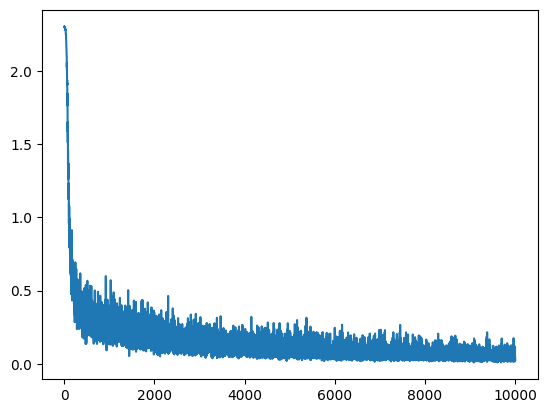

In [27]:
x_points = np.arange(iters_num)
print(x_points)
print(train_loss_list)
plt.plot(x_points, train_loss_list)